In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [1]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = 'M:/Alzheimers-ADNI/train'
TEST_DIR =  'M:/Alzheimers-ADNI/test'

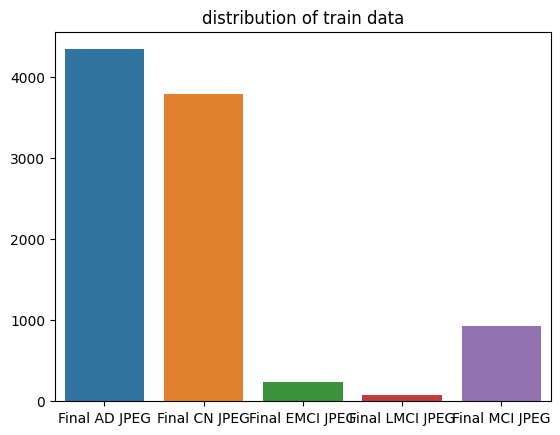

9350


In [8]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)

In [9]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

In [10]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 12961 images belonging to 5 classes.
Found 3239 images belonging to 5 classes.
Found 2575 images belonging to 5 classes.


In [11]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
print(base_model.summary())

58889256/58889256 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                             

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(input, output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [14]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [15]:
h = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 36s 1s/step - loss: 1.6674 - accuracy: 0.5255 - val_loss: 3.9727 - val_accuracy: 0.3021
Epoch 2/10
27/27 [==============================] - 34s 1s/step - loss: 0.9084 - accuracy: 0.5648 - val_loss: 3.0576 - val_accuracy: 0.3229
Epoch 3/10
27/27 [==============================] - 34s 1s/step - loss: 0.7832 - accuracy: 0.5926 - val_loss: 3.9551 - val_accuracy: 0.3229
Epoch 4/10
27/27 [==============================] - 35s 1s/step - loss: 0.7406 - accuracy: 0.5799 - val_loss: 3.5652 - val_accuracy: 0.2135
Epoch 5/10
27/27 [==============================] - 33s 1s/step - loss: 0.6694 - accuracy: 0.6157 - val_loss: 4.8472 - val_accuracy: 0.3125
Epoch 6/10
27/27 [==============================] - 32s 1s/step - loss: 0.6642 - accuracy: 0.6343 - val_loss: 4.5186 - val_accuracy: 0.2865
Epoch 7/10
27/27 [==============================] - 32s 1s/step - loss: 0.6876 - accuracy: 0.6215 - val_loss: 4.4123 - val_accuracy: 0.2396
Epoch 8/10
27/27 [==

In [16]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [17]:
print(f"VGG16- number of layers: {len(base_model.layers)}")
for layer in base_model.layers:
    print(f"{layer.name} trainable? {layer.trainable}")

VGG16- number of layers: 19
input_1 trainable? False
block1_conv1 trainable? False
block1_conv2 trainable? False
block1_pool trainable? False
block2_conv1 trainable? False
block2_conv2 trainable? False
block2_pool trainable? False
block3_conv1 trainable? False
block3_conv2 trainable? False
block3_conv3 trainable? False
block3_pool trainable? False
block4_conv1 trainable? True
block4_conv2 trainable? True
block4_conv3 trainable? True
block4_pool trainable? True
block5_conv1 trainable? True
block5_conv2 trainable? True
block5_conv3 trainable? True
block5_pool trainable? True


In [18]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [19]:
h1 = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 77s 3s/step - loss: 7.1199 - accuracy: 0.4329 - val_loss: 1.1719 - val_accuracy: 0.5208
Epoch 2/10
27/27 [==============================] - 79s 3s/step - loss: 0.9847 - accuracy: 0.4340 - val_loss: 0.9592 - val_accuracy: 0.5000
Epoch 3/10
27/27 [==============================] - 95s 4s/step - loss: 0.8679 - accuracy: 0.4803 - val_loss: 1.1585 - val_accuracy: 0.4062
Epoch 4/10
27/27 [==============================] - 95s 4s/step - loss: 0.7921 - accuracy: 0.4803 - val_loss: 1.2114 - val_accuracy: 0.4010
Epoch 5/10
27/27 [==============================] - 82s 3s/step - loss: 1.3033 - accuracy: 0.4769 - val_loss: 1.0578 - val_accuracy: 0.5000
Epoch 6/10
27/27 [==============================] - 88s 3s/step - loss: 1.0249 - accuracy: 0.4491 - val_loss: 0.9879 - val_accuracy: 0.4583
Epoch 7/10
27/27 [==============================] - 84s 3s/step - loss: 0.9268 - accuracy: 0.4780 - val_loss: 0.9727 - val_accuracy: 0.4167
Epoch 8/10
27/27 [==

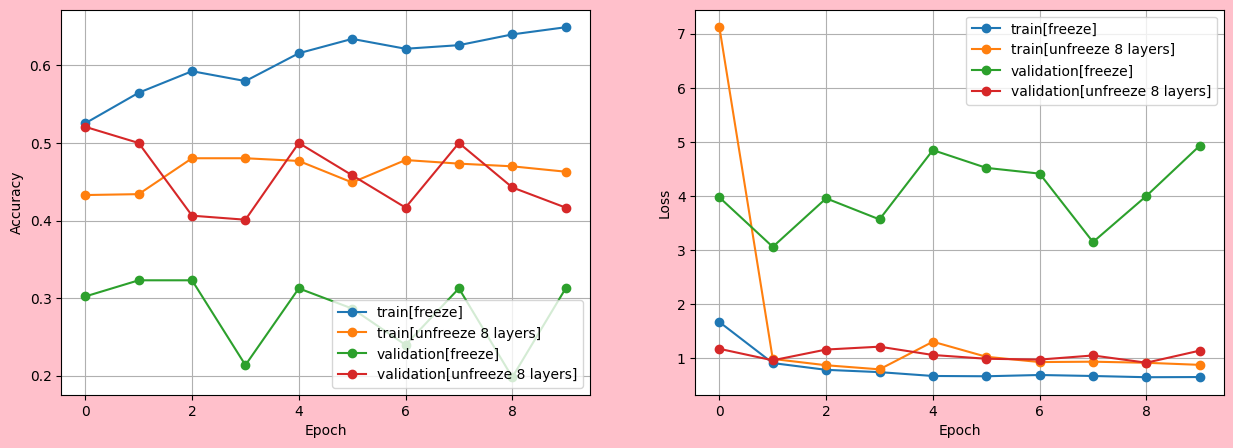

In [20]:
plt.figure(figsize=(15,5), facecolor='pink')
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train[freeze]')
plt.plot(h1.history['accuracy'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_accuracy'], 'o-', label = 'validation[freeze]')
plt.plot(h1.history['val_accuracy'], 'o-', label = 'validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train[freeze]')
plt.plot(h1.history['loss'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_loss'], 'o-', label='validation[freeze]')
plt.plot(h1.history['val_loss'], 'o-', label='validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()